# Create Pickled Data

The vehicle and non-vehicle dataset from GTI image database contain time-series images. In order to create a robust classifier, it is necessary to manually extract only one image for each vehicle. Otherwise, no matter how data is train-test split, it is possible to have very similar images in both training and testing dataset. After images are carefully selected, they will be stored in pickled files and ready for use in the project.

## Read GTI and KITTI Dataset

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# read vehicle images
vehicle_images = [] 
gti_vehicle_images = glob.glob('./vehicles/vehicles/GTI*/*.png')
kitti_vehicle_images = glob.glob('./vehicles/vehicles/KI*/*.png')
# add all KITTI vehicle images
vehicle_images.extend(kitti_vehicle_images)
# extract GTI images at a step of 10
sub_gti_vehicle_images = gti_vehicle_images[0::10]
vehicle_images.extend(sub_gti_vehicle_images)
print('Vehicle image size is {}'.format(len(vehicle_images)))

# read non-vehicle images
non_vehicle_images = glob.glob('./non_vehicles/non_vehicles/*/*.png')
print ('Non vehicle image size is {}'.format(len(non_vehicle_images)))

Vehicle image size is 6249
Non vehicle image size is 8968


Now that a subset of images are extracted from the GTI image database, it is immediately found that the dataset is not balanced. In order to balance the dataset, data augmentation is required for vehicle images. There are several ways to do this.
* Data augmentation based on existing images, e.g, flip image, add random contrast, shadow, warp
* Add new data from other image database
In this project, images from CrowdAI databased are used to supplement and balance the dataset.

## Include CrowdAI Dataset

In [2]:
import pandas as pd

# read CrowdAI image database
crowdai_df = pd.read_csv('./object_detection_crowdai/labels.csv')
# preview dataframe
crowdai_df.head()

,xmin,xmax,ymin,ymax,Frame,Label,Preview URL
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3,455,522,548,615,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4,548,522,625,605,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


For this project only cars are extracted from the CrowdAI database. 

In [3]:
crowdai_cars = crowdai_df.loc[crowdai_df['Label'] == 'Car']
crowdai_cars.head()

,xmin,xmax,ymin,ymax,Frame,Label,Preview URL
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
5,1726,484,1919,646,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
6,758,557,807,617,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


Next, figure out how many images are needed to be added to vehicle dataset and randomly select images from the database.

In [4]:
n_additional_images = len(non_vehicle_images) - len(vehicle_images)
print('Need {} additional images'.format(n_additional_images))
# seed the generator to keep the results reproducable
np.random.seed(40)
print('Number of unique frames in CrowdAI database')
#print(crowdai_cars.size)
print(crowdai_cars['Frame'].nunique())

Need 2719 additional images
Number of unique frames in CrowdAI database
9130


Again, the CrowdAI database is based on frames captures on the road at 2Hz. It is necessary to select images with sufficient interval to make the data useful. 
First of all, it is helpful to know the minimum number of cars that can be extracted from each frame.

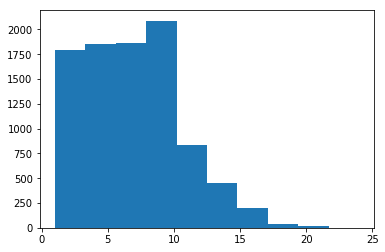

In [5]:
frames = crowdai_cars.groupby('Frame')
# get a list for each frame
frame_info =[x[1] for x in list(frames)]
# get minimum number of cars in a frame
n_min = [len(x) for x in frame_info]
# show min counts in a histogram
plt.hist(n_min, bins=10)
plt.show()

It seems that there a quite a few frames that have number of cars less than 5.

In [6]:
# use pandas filter to get frames with more than 5 cars in the image
good_frames = frames.filter(lambda x: len(x) >= 5)
good_frames.head(30)
print('Number of frames with at least 5 cars in the image:')
print(good_frames['Frame'].nunique())

Number of frames with at least 5 cars in the image:
6434


It is known that 2719 additional car images are need. There are 6434 frames with at least 5 cars in the image. Therefore, images should be extracted at an interval of 6434/(2719/5) = 11.

In [7]:
# first, drop duplicated frames
extracted_frames = good_frames.drop_duplicates(['Frame'], keep='last')
# reset index so that we can use fixed step slicing
extracted_frames = extracted_frames.reset_index(drop=True)
# extract frame every 11 frames
extracted_frames = extracted_frames.iloc[::11]
print('Number of final extracted frames:')
print(extracted_frames['Frame'].count())

Number of final extracted frames:
585


Now, 585 unique frames with at least 5 cars in each frame are extracted from the dataset. It is not guaranteed that each frame is unique though, as a fixed step extraction is used. If the car collecting the frames stops at red light for a long time, there will be more than 11 frames with the very similar image. However, reasonable effort has been taken to reduce the chance of this problem happening.

The next step is to extract car bounding box in the frames just extracted. Cars should be extracted from each image and saved as .png files.

In [8]:
frames_of_interest = crowdai_cars[crowdai_cars['Frame'].isin(extracted_frames['Frame'])]
frames_of_interest['Frame'].count()

5005

There are 5005 cars that can be extracted and only 2719 of them are needed.

In [9]:
crowdai_sample = frames_of_interest.sample(n=2719, random_state=40)

Now, define a function that takes in a dataframe, read the image for each frame, extract cars according to the bounding boxes, resize them and then save the image a car image in png format.

In [10]:
import os
crowdai_path = 'object_detection_crowdai/'
save_path = 'vehicle_crowdai/'

def car_from_crowdai(dataframe):
    for index, row in dataframe.iterrows():
        image = os.path.join(crowdai_path, row['Frame'])
        img = cv2.imread(image)
        #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,8))
        #ax1.imshow(img)
        xmin = row['xmin']
        xmax = row['xmax']
        ymin = row['ymin']
        ymax = row['ymax']
        top_left = (xmin, xmax)
        bot_right = (ymin, ymax)
        car_img = img[xmax:ymax, xmin:ymin]
        #car_img = cv2.rectangle(img, top_left, bot_right, (0,255,0),4)
        #f = plt.plot(figsize=(24,8))
        #ax2.imshow(car_img)
        resized = cv2.resize(car_img, (64, 64))
        cv2.imwrite(save_path+str(index)+".png",resized)
    print("Vehicle images successfully created.")

In [11]:
car_from_crowdai(crowdai_sample)

Vehicle images successfully created.


Now that the supplementary data has been generated, they can be included in the `vehicles_images` list.

In [12]:
crowdai_vehicle_images = glob.glob('./vehicle_crowdai/*.png')
vehicle_images.extend(crowdai_vehicle_images)
print('Vehicle image size is {}'.format(len(vehicle_images)))

Vehicle image size is 8968


Now the vehicle set and non-vehicle set are balanced.

## Save Dataset

In [13]:
# read images and create a list
veh_img = []
non_veh_img = []
for img_file in vehicle_images:
    # read png file and results in range(0,255)
    img = cv2.imread(img_file)
    veh_img.append(img)

for img_file in non_vehicle_images:
    img = cv2.imread(img_file)
    non_veh_img.append(img)

data = {'vehicle_images': veh_img, 'non_vehicle_images': non_veh_img}
print ("Writing pickle file.")
with open('dataset.pickle', 'wb') as f:
    pickle.dump(data, f)
    print ("Writing done.")

Writing pickle file.
Writing done.


In [14]:
# test pickle file

with open('dataset.pickle', 'rb') as f:
    data = pickle.load(f)
    print("Data loaded.")
    
veh_img_test = data['vehicle_images']
non_veh_img_test = data['non_vehicle_images']

Data loaded.


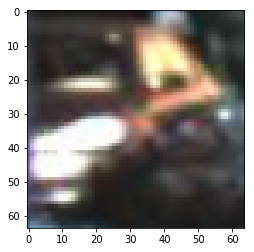

In [15]:
plt.imshow(veh_img_test[np.random.randint(0,len(veh_img_test))])

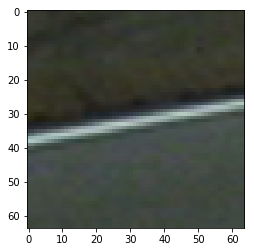

In [16]:
plt.imshow(non_veh_img_test[np.random.randint(0,len(non_veh_img_test))])